In [1]:
import os
import glob
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm.auto import tqdm
from IPython.core.display import display, HTML

from gensit.config import Config
from gensit.inputs import Inputs
from gensit.outputs import Outputs
from gensit.utils.misc_utils import *
from gensit.utils.math_utils import *
from gensit.utils.probability_utils import *
from gensit.contingency_table import instantiate_ct
from gensit.contingency_table_mcmc import ContingencyTableMarkovChainMonteCarlo

/tmp/ipykernel_234110/2303974116.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

# Sandbox

In [36]:
# Create new logging object
logger = setup_logger(
    __name__,
    console_level = 'PROGRESS',
    file_level = 'EMPTY'
)
conf = Config(
    path = '../data/inputs/configs/DC/experiment1_mcmc_disjoint.toml',
    logger = logger
)
conf.settings['sweep_mode'] = False
conf.settings['inputs']['dataset'] = 'temp'
conf.settings['training']['to_learn'] = ['alpha','beta']
conf.settings['harris_wilson_model']['parameters']['sigma'] = 0.014141414
conf.settings['mcmc']['parameters']['covariance'] = conf.settings['mcmc']['parameters']['covariance']['sweep']['range'][0]

In [ ]:
np.random.seed(1234)
I,J = 6,4
gtt = np.random.randint(1,15,size=(6*4)).reshape((I,J))
cm = np.random.rand(I,J)
dats = np.random.rand(J)
gtt[(0,1)] = 0
gtt[(2,3)] = 0
cell_constraints = np.array([(0,1),(0,2),(2,1),(2,3),(3,1),(4,3)])
try:
    os.mkdir("../data/inputs/temp")
except:
    pass
np.savetxt('../data/inputs/temp/ground_truth_table.txt',gtt)
np.savetxt('../data/inputs/temp/zero_and_train_cells.txt',cell_constraints)
np.savetxt('../data/inputs/temp/origin_demand_sum_normalised.txt',gtt.sum(axis=1)/gtt.sum())
np.savetxt('../data/inputs/temp/cost_matrix_max_normalised.txt',cm/cm.max())
np.savetxt('../data/inputs/temp/destination_attraction_housing_units_ts_sum_normalised.txt',dats/dats.sum())

In [ ]:
# Prepare inputs
ins = Inputs(
    config = conf,
    synthetic_data = False,
    logger = logger 
)

# Pass inputs to device
ins.pass_to_device()

# Instantiate contingency table
conf_without_cell_constraints = deepcopy(conf)
conf_without_cell_constraints['contingency_table']['constraints']['cells'] = ''

ct_with_cell_constraints = instantiate_ct(
    config = conf,
    **vars(ins.data),
    logger = logger
)
ct_without_cell_constraints = instantiate_ct(
    config = conf_without_cell_constraints,
    **vars(ins.data),
    logger = logger
)

conf.settings['contingency_table']['distribution_name'] = ct_with_cell_constraints.distribution_name
conf_without_cell_constraints.settings['contingency_table']['distribution_name'] = ct_without_cell_constraints.distribution_name

ct_mcmc_with_cell_constraints = ContingencyTableMarkovChainMonteCarlo(
    ct = ct_with_cell_constraints,
    log_to_console = False,
    logger = logger
)
ct_mcmc_without_cell_constraints = ContingencyTableMarkovChainMonteCarlo(
    ct = ct_without_cell_constraints,
    log_to_console = False,
    logger = logger
)

In [ ]:
def _coloring_function(val):
    color = 'green' if val < 0 else 'red'
    return 'color: %s' % color
constraint_table = pd.DataFrame(ct_with_cell_constraints.constraint_table())
constraint_table = constraint_table.style.applymap(_coloring_function)

In [ ]:
print('Without cell constraints',len(ct_mcmc_without_cell_constraints.markov_basis))
print('With cell constraints',len(ct_mcmc_with_cell_constraints.markov_basis))

In [ ]:
for mb in ct_mcmc_without_cell_constraints.markov_basis:
    print(f_to_array(mb,shape=(I,J)))
    print('\n')

In [ ]:
for mb in ct_mcmc_with_cell_constraints.markov_basis:
    print(f_to_array(mb,shape=(I,J)))
    display(constraint_table)
    print('\n')

## Import samples

In [3]:
# Specify experiment id
experiment_id = "SIM_NN_SweepedNoise__doubly_and_cell_constrained_unnormalised_cost_matrix_16_04_2024_19_29_39"
# Specify experiment group id
dataset = 'DC'
#'DC'
#'cambridge_work_commuter_lsoas_to_msoas'
#'sioux_falls'
experiment_group_id = 'exp1'
# 'r_squared'
# 'exp1'
experiment_dir = f'../data/outputs/{dataset}/{experiment_group_id}/{experiment_id}/'
relative_experiment_dir = os.path.relpath(experiment_dir,os.getcwd())

In [4]:
# Create new logging object
logger = setup_logger(
    __name__,
    console_level = 'PROGRESS',
    file_level = 'EMPTY'
)

In [6]:
# Output processing settings
settings = {
    "logging_mode": "PROGRESS",
    "coordinate_slice": [
        "da.loss_name == str(['dest_attraction_ts_likelihood_loss'])",
        # "da.cost_matrix == 'cost_matrix_max_normalised.txt'"
    ],
    # "coordinate_slice": [
    #     "da.destination_attraction_ts == 'destination_attraction_housing_units_ts_sum_normalised.txt'",
    #     "da.cost_matrix == 'cost_matrix_sum_normalised.txt'",
    #     "da.title == '_row_constrained'",
    #     "da.bmax == 1.0"
    #     # "da.loss_name == str(['dest_attraction_ts_likelihood_loss'])",
    #     # "~da.title.isin([str('_unconstrained'), str('_total_constrained')])"
    # ],
    "metadata_keys":[],
    "burnin_thinning_trimming": [],
    # "burnin_thinning_trimming": [{'iter': {"burnin":10000, "thinning":90, "trimming":1000}}],
    "n_workers": 1,
    "group_by":[],
    "filename_ending":"test",
    "sample":["intensity","table"],
    "force_reload":True
}

In [7]:
# Initialise outputs
current_sweep_outputs = Outputs(
    config = os.path.join(relative_experiment_dir,"config.json"),
    settings = settings,
    inputs = None,
    slice = True,
    level = 'INFO'
)
# Silence outputs
# current_sweep_outputs.logger.setLevels(console_level='EMPTY')
# Load all data
current_sweep_outputs.load()

print(len(current_sweep_outputs.data),'experiments matched')

01:33.585 config INFO ----------------------------------------------------------------------------------
01:33.594 config INFO Parameter space size: 
 --- cost_matrix (2)
 --- sigma: ['sigma', 'to_learn'] (3)
 --- loss_name: ['loss_name', 'loss_function', 'loss_kwargs'] (2)
01:33.603 config INFO Total = 12.
01:33.611 config INFO ----------------------------------------------------------------------------------
01:33.630 outputs INFO //////////////////////////////////////////////////////////////////////////////////
01:33.638 outputs INFO Slicing coordinates:
01:33.647 outputs INFO loss_name == str(['dest_attraction_ts_likelihood_loss'])
01:33.655 outputs INFO //////////////////////////////////////////////////////////////////////////////////
01:33.664 outputs WARNING Removing ../data/outputs/DC/exp1/SIM_NN_SweepedNoise__doubly_and_cell_constrained_unnormalised_cost_matrix_16_04_2024_19_29_39/sample_collections
01:33.767 outputs INFO Collecting samples alpha, beta, log_destination_attract

6 experiments matched


In [ ]:
# conf = Config(
#     path = os.path.join(relative_experiment_dir,"config.json")
# )
# ins = Inputs(
#     config = conf
# )
# ins.cast_to_xarray()

# $R^2$ analysis

In [ ]:
sweep_outputs_slices = []
for i in tqdm(range(len(current_sweep_outputs.data)),leave=False,desc='Finding best R2 experiments'):
    current_sweep_outputs_slice = current_sweep_outputs.get(i)
    current_r2 = current_sweep_outputs_slice.data.r2
    if np.max(current_r2) > 0.6:
        sweep_outputs_slices.append(current_sweep_outputs_slice)
print(len(sweep_outputs_slices),'experiments kept')

In [ ]:
# index = 15
# sweep_outputs_slice = sweep_outputs_slices[index]

In [ ]:
# data_index = 0
# sweep_outputs_slice = current_sweep_outputs.get(data_index)

In [ ]:
r2 = sweep_outputs_slice.data.r2
alpha_range = current_sweep_outputs.config['experiments'][0]['grid_ranges']['alpha']
r2['alpha_range'] = np.linspace(alpha_range['min'],alpha_range['max'],alpha_range['n'],endpoint=True)
r2['alpha_range'] = r2['alpha_range'].values
beta_range = current_sweep_outputs.config['experiments'][0]['grid_ranges']['beta']
r2['beta_range'] = np.linspace(beta_range['min'],beta_range['max'],beta_range['n'],endpoint=True)
r2['beta_range'] = r2['beta_range'].values
r2.coords

In [ ]:
argmax_index = np.unravel_index(np.argmax(r2.values.squeeze()), np.shape(r2.values.squeeze()))
plt.figure(figsize=(20,20))
plt.imshow(r2, cmap='RdYlGn', interpolation='nearest')
plt.scatter(argmax_index[1],argmax_index[0],marker='x',color='black',s=500)
plt.yticks(ticks=range(len(r2['alpha_range'])),labels=np.round(r2['alpha_range'].values,2))
plt.ylabel('alpha')
plt.xticks(ticks=range(len(r2['beta_range'])),labels=np.round(r2['beta_range'].values,2))
plt.xlabel('beta')
for i in range(len(r2['alpha_range'])):
    for j in range(len(r2['beta_range'])):
        plt.text(j,i,s=np.round(r2.squeeze().values[i,j],2),fontsize=8)
plt.show()

# SIM Analysis

In [57]:
index = 4
current_data = current_sweep_outputs.get(index)
print('# Sweeps:',len(current_sweep_outputs.data))
print(current_data.data.alpha.coords.items())

# Sweeps: 6
ItemsView(Coordinates:
  * id             (id) object MultiIndex
  * iter           (id) int32 1 2 3 4 5 6 ... 99996 99997 99998 99999 100000
  * sweep          (sweep) object MultiIndex
  * cost_matrix    (sweep) <U30 'cost_matrix_max_normalised.txt'
  * sigma          (sweep) float32 0.1414
  * to_learn       (sweep) <U17 "['alpha', 'beta']"
  * loss_name      (sweep) <U38 "['dest_attraction_ts_likelihood_loss']"
  * loss_function  (sweep) <U10 "['custom']"
  * loss_kwargs    (sweep) <U26 "{'noise_percentage': None}")


In [58]:
ins = Inputs(
    config = current_data.config
)
ins.cast_to_xarray()

Text(0, 0.5, 'Data')

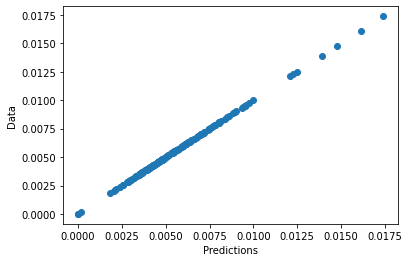

In [59]:
_ = plt.scatter(
    np.exp(current_data.data.log_destination_attraction).mean('id').values.squeeze(),
    ins.data.destination_attraction_ts.squeeze()
)
plt.xlabel("Predictions")
plt.ylabel("Data")

Text(0.5, 0, 'alpha')

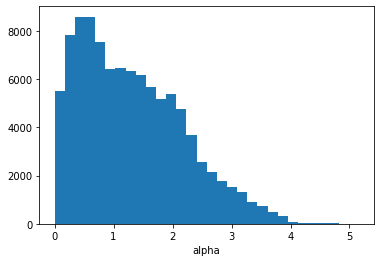

In [60]:
_ = plt.hist(current_data.data.alpha.squeeze().values,bins=30)
plt.xlabel('alpha')

Text(0.5, 0, 'beta')

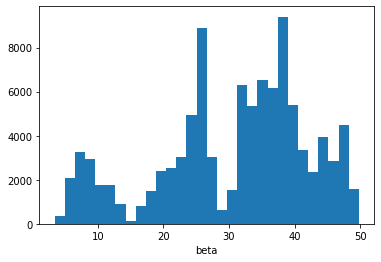

In [61]:
_ = plt.hist(current_data.data.beta.squeeze().values,bins=30)
plt.xlabel('beta')

Text(0.5, 0, 'beta')

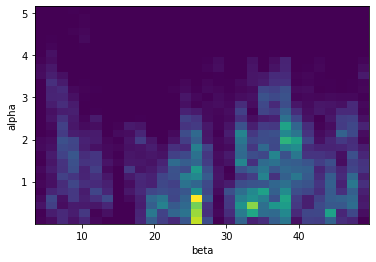

In [62]:
_ = plt.hist2d(
    current_data.data.beta.squeeze().values,
    current_data.data.alpha.squeeze().values,
    bins = 30
)
plt.ylabel('alpha')
plt.xlabel('beta')